<a href="https://colab.research.google.com/github/rayyirahmaid/Clothing-Classification-Model-with-CNN-and-YOLO/blob/main/Clothing_Classification_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import shutil
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import timm

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, KFold
from torch import nn
from torch.utils.data import DataLoader, Subset
from torchvision import transforms, datasets, models
from torchvision.models import alexnet
from google.colab import drive

In [3]:
# Mount Drive ke memori google collab
drive.mount('/content/drive')

# Path ke dataset utama
dataset_path = '/content/drive/My Drive/processed_dataset'  # Ganti dengan path dataset utama Anda

# Path ke folder train dan test di /content
train_dir = "/content/train"  # Path untuk training
test_dir = "/content/test"  # Path untuk testing

# Membuat folder Train dan Test
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Step 4: Loop untuk setiap kelas dalam folder Dataset
for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):  # Pastikan hanya memproses folder kelas
        print(f"Memproses kelas: {class_name}")

        # Buat folder untuk kelas ini di Train dan Test
        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

        # Ambil semua file dari kelas
        all_files = [os.path.join(class_path, f) for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]

        # Bagi file ke training (70%) dan testing (30%) secara acak
        train_files, test_files = train_test_split(all_files, test_size=0.3, random_state=42)

        # Pindahkan file ke folder Train dan Test
        for file in train_files:
            shutil.copy(file, os.path.join(train_dir, class_name))
        for file in test_files:
            shutil.copy(file, os.path.join(test_dir, class_name))

print("Dataset telah berhasil dibagi menjadi Train dan Test!")
print(f"Folder Train: {train_dir}")
print(f"Folder Test: {test_dir}")

Mounted at /content/drive
Memproses kelas: bajuterang
Memproses kelas: bajugelap
Memproses kelas: celanagelap
Memproses kelas: celanaterang
Memproses kelas: rokgelap
Memproses kelas: rokterang
Dataset telah berhasil dibagi menjadi Train dan Test!
Folder Train: /content/train
Folder Test: /content/test


In [3]:
# Load Dataset
batch_size = 32
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [4]:
# Load Model
num_classes = len(train_dataset.classes)
model = alexnet(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 20

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


100%|██████████| 233M/233M [00:02<00:00, 105MB/s]


In [5]:
# Training Loop
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)
    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)

    # Validation Loop
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(outputs.argmax(1).cpu().numpy())
    val_loss = running_loss / len(test_loader)
    val_acc = correct / total
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

Epoch 1/20, Train Loss: 1.4701, Train Acc: 0.4161, Val Loss: 0.9681, Val Acc: 0.6302
Epoch 2/20, Train Loss: 0.9384, Train Acc: 0.6135, Val Loss: 0.8350, Val Acc: 0.6792
Epoch 3/20, Train Loss: 0.7119, Train Acc: 0.7319, Val Loss: 0.8173, Val Acc: 0.6792
Epoch 4/20, Train Loss: 0.6963, Train Acc: 0.7253, Val Loss: 0.7220, Val Acc: 0.7094
Epoch 5/20, Train Loss: 0.6103, Train Acc: 0.7664, Val Loss: 0.8316, Val Acc: 0.6981
Epoch 6/20, Train Loss: 0.5895, Train Acc: 0.7796, Val Loss: 0.6650, Val Acc: 0.7547
Epoch 7/20, Train Loss: 0.5149, Train Acc: 0.7961, Val Loss: 0.6362, Val Acc: 0.7547
Epoch 8/20, Train Loss: 0.4647, Train Acc: 0.8322, Val Loss: 0.6521, Val Acc: 0.7547
Epoch 9/20, Train Loss: 0.4584, Train Acc: 0.8257, Val Loss: 0.6915, Val Acc: 0.7283
Epoch 10/20, Train Loss: 0.4687, Train Acc: 0.8240, Val Loss: 0.7048, Val Acc: 0.7283
Epoch 11/20, Train Loss: 0.4549, Train Acc: 0.8355, Val Loss: 0.5914, Val Acc: 0.7698
Epoch 12/20, Train Loss: 0.4021, Train Acc: 0.8701, Val Loss: 0

In [6]:
# Menyimpan model ke file
model_path = "/content/drive/My Drive/saved_model.pth"  # Ganti dengan path penyimpanan Anda
torch.save(model.state_dict(), model_path)
print(f"Model telah disimpan ke {model_path}")

Model telah disimpan ke /content/drive/My Drive/saved_model.pth


Classification Report:
              precision    recall  f1-score   support

   bajugelap       0.80      0.83      0.82        48
  bajuterang       0.72      0.86      0.79        49
 celanagelap       0.80      0.78      0.79        45
celanaterang       0.65      0.83      0.73        42
    rokgelap       0.84      0.65      0.73        40
   rokterang       0.75      0.51      0.61        41

    accuracy                           0.75       265
   macro avg       0.76      0.74      0.74       265
weighted avg       0.76      0.75      0.75       265



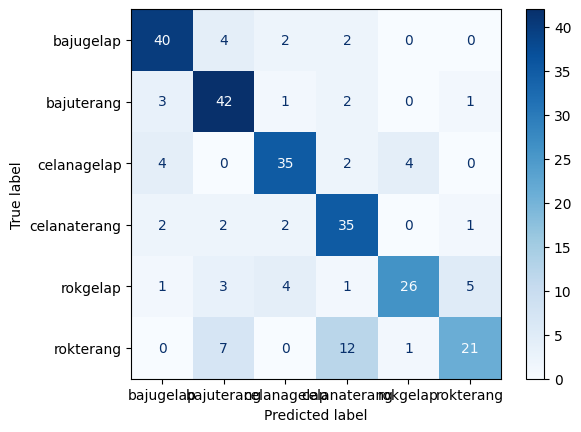

In [7]:
# Evaluation and Metrics
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=train_dataset.classes))
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.classes)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.show()

In [8]:
# Import Dataset
train_dir = '/content/train'  # Make sure this points to your training data
model_save_path = '/content/vit_clothing_model.pth'
batch_size = 32
num_epochs = 20  # Start with 5-10 epochs to see how it performs
learning_rate = 0.001

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Training on device: {device}")

Training on device: cpu


In [1]:
%pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 29.0 MB/s eta 0:00:00


In [5]:
from ultralytics import YOLO

# 1. Load model pre-trained bawaan (sudah pintar berkat ImageNet)
model = YOLO('yolov8n-cls.pt')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 2. Latih LANGSUNG menggunakan dataset pakaian Anda sendiri
# Ganti path '/content/dataset_pakaian' dengan lokasi folder dataset Anda.
results = model.train(
    data='/content/yolo-dataset',  # Path ke folder dataset Anda
    epochs=20,                        # Jumlah iterasi
    imgsz=224,                        # Pakai ukuran 224 karena gambar Anda cukup detail
    device=device                         # Gunakan GPU
)

engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/yolo-dataset, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=224, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n-cls.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True, profile=False, project=None, rect=False, 

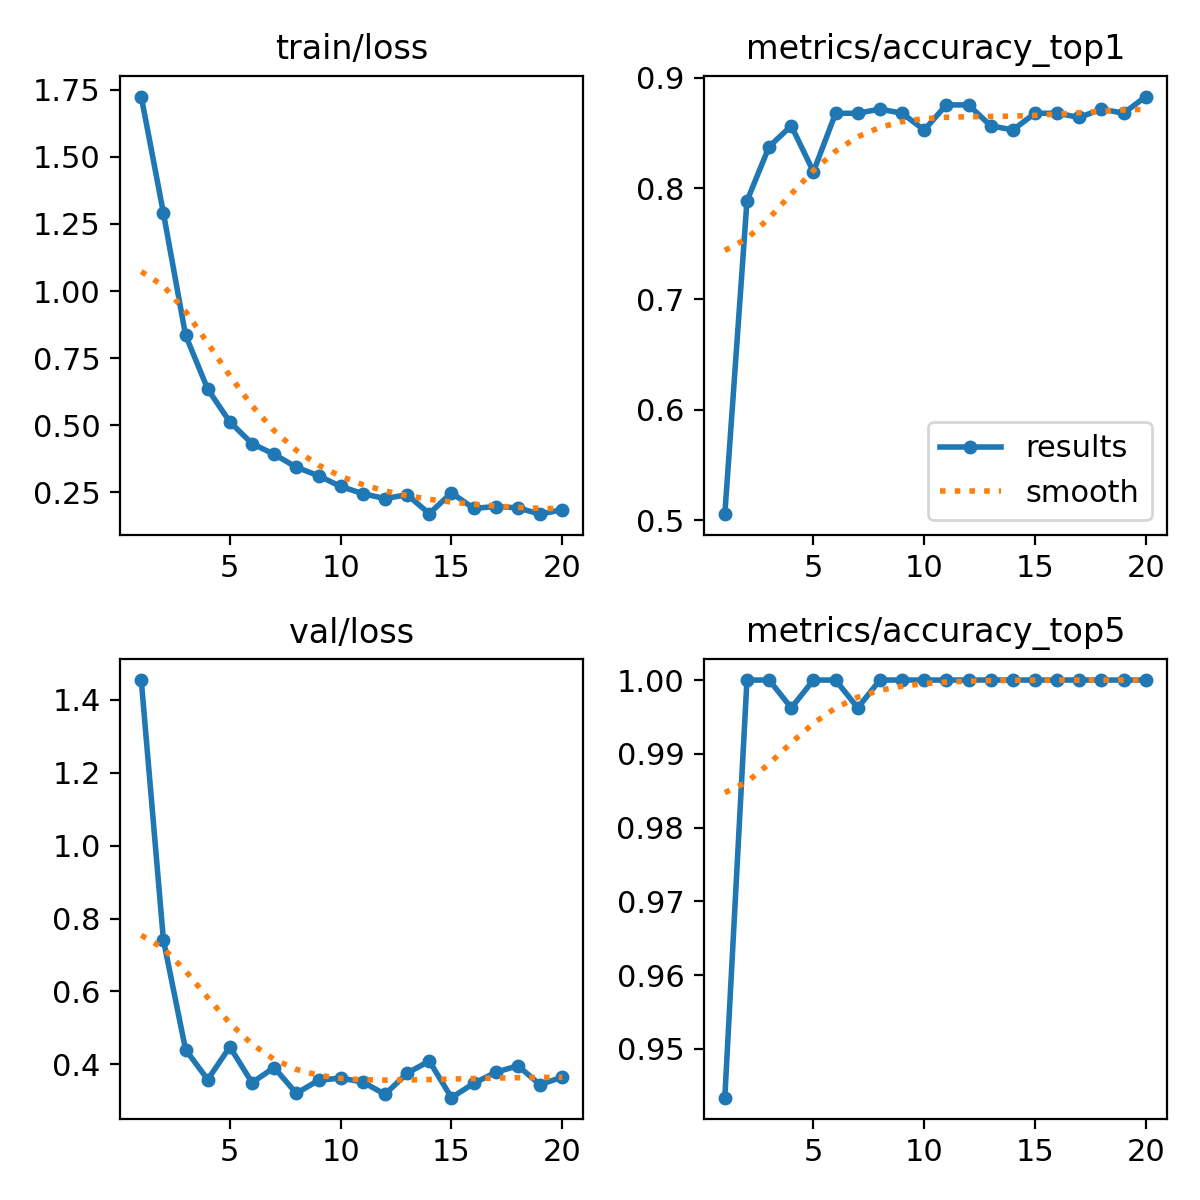

In [7]:
from IPython.display import Image, display

# Menampilkan grafik garis perbandingan keseluruhan
display(Image(filename='runs/classify/train/results.png', width=800))

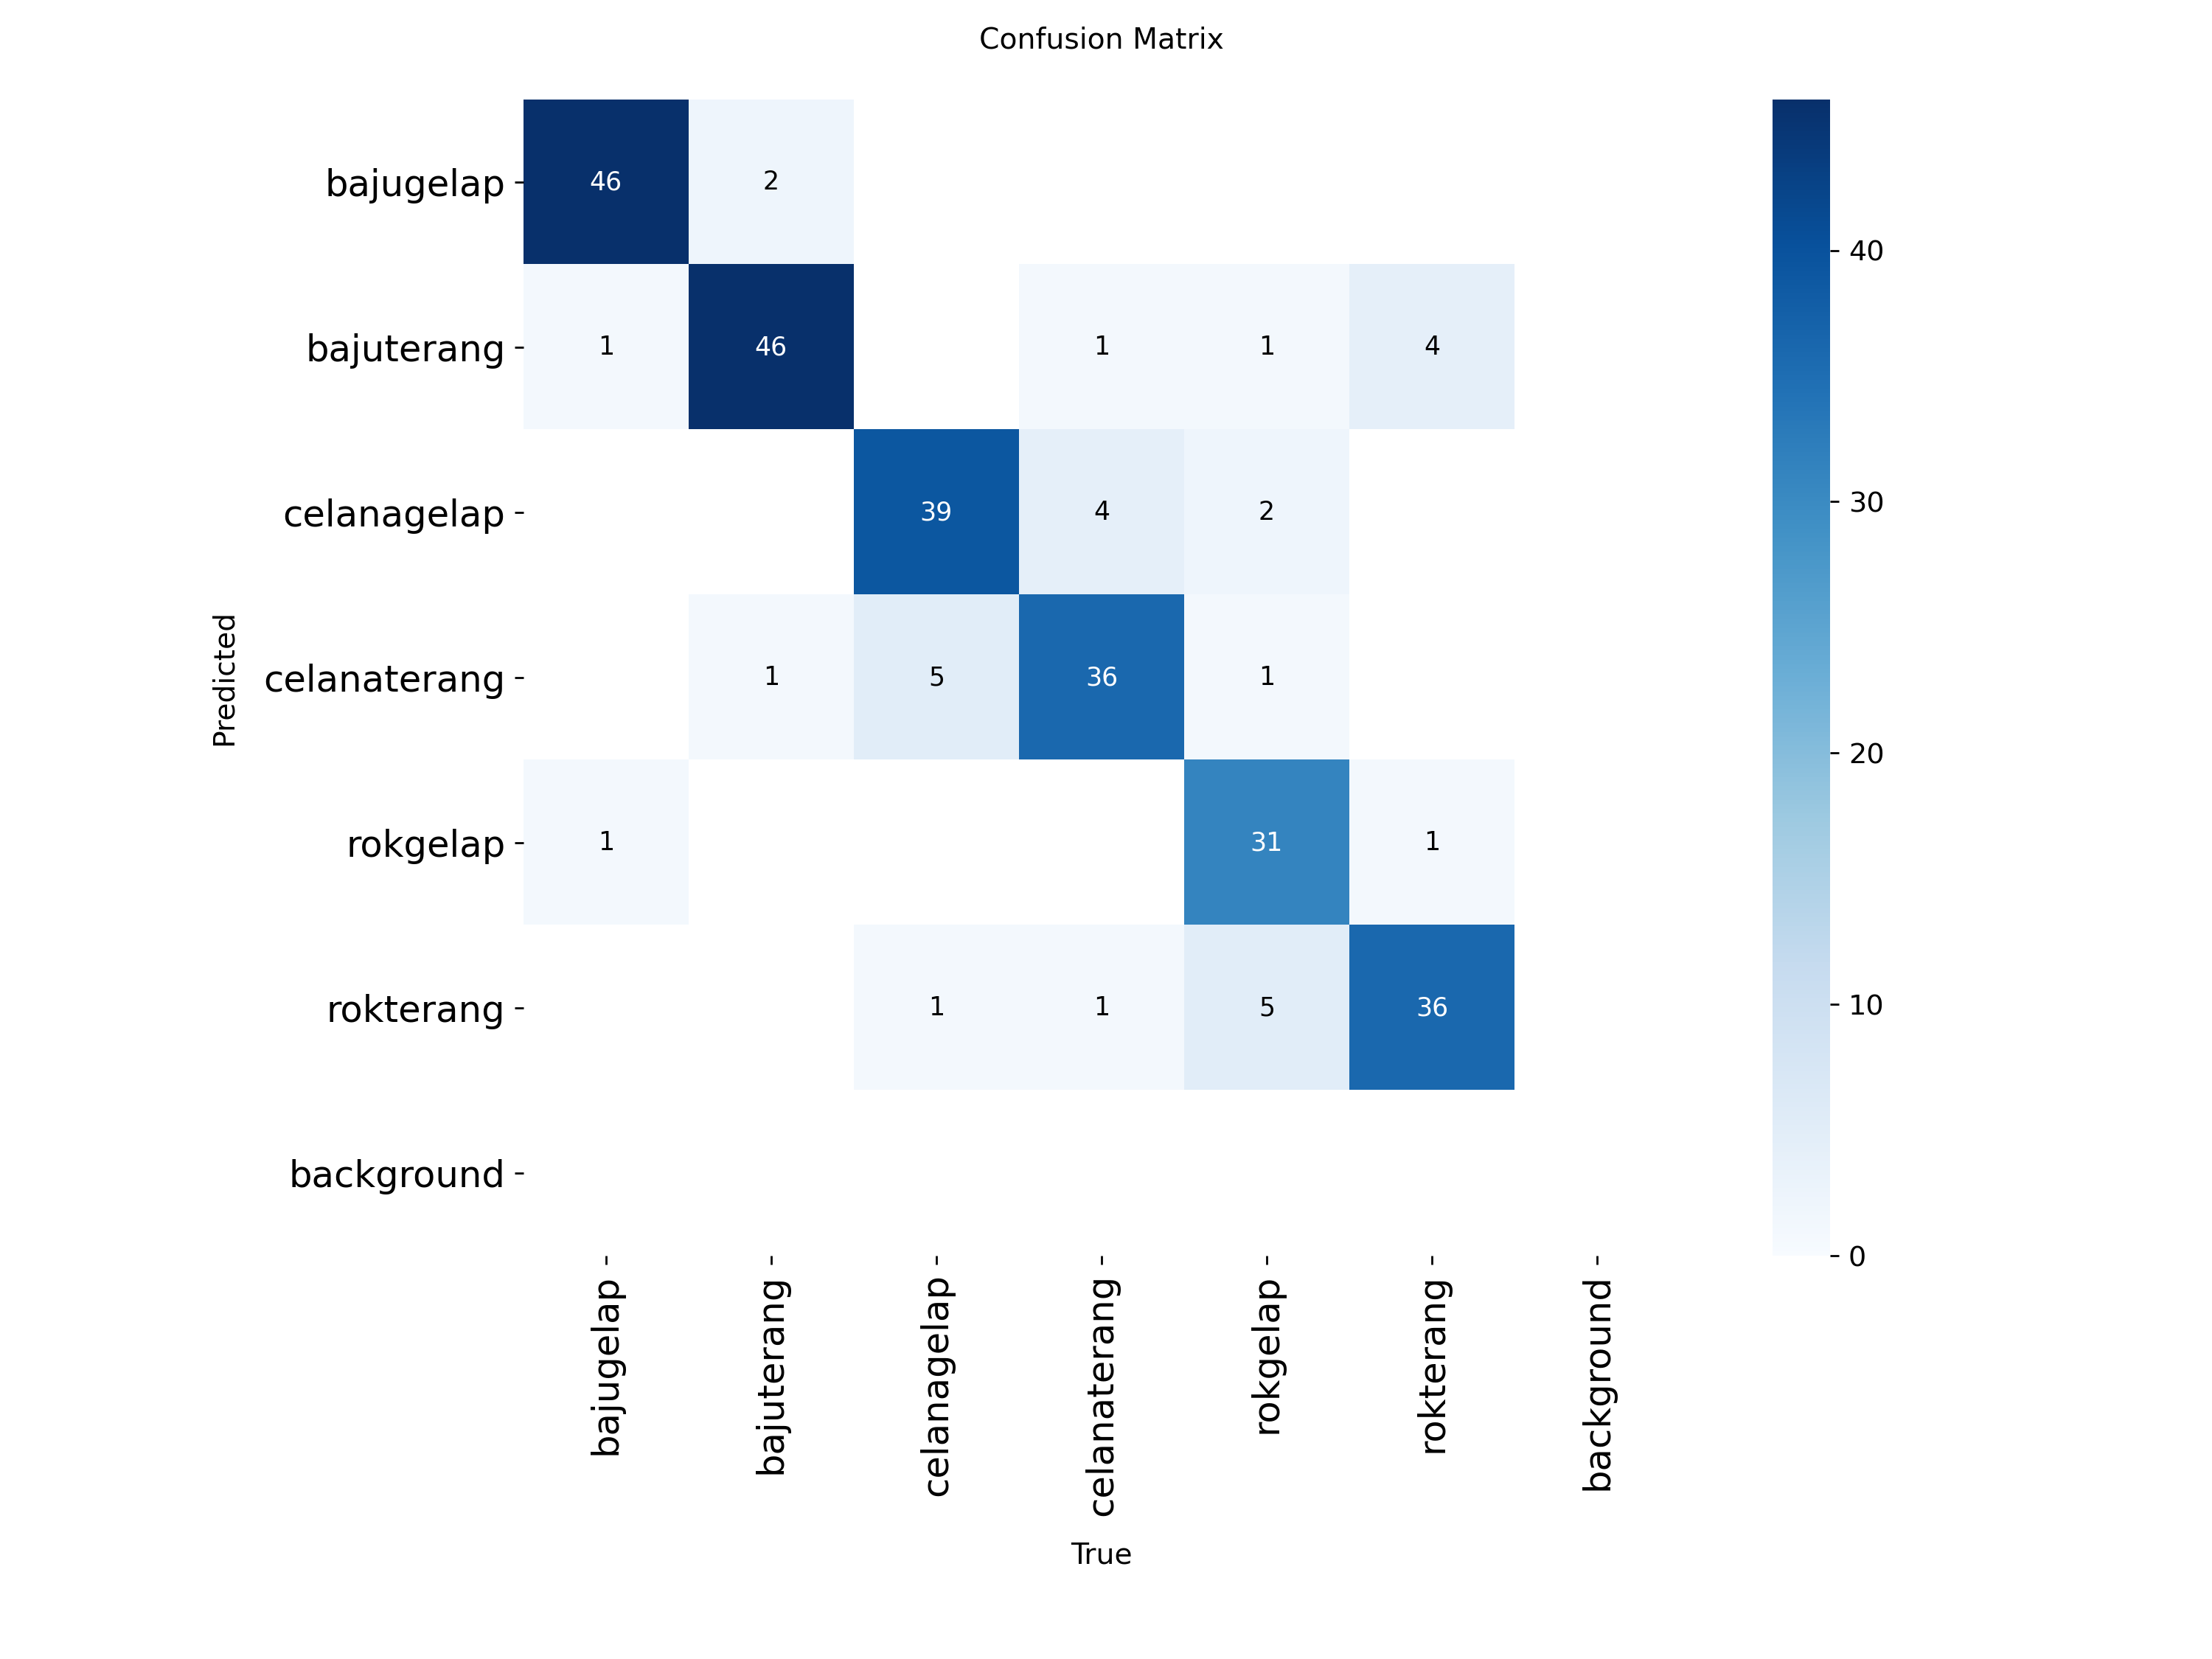

In [8]:
# Menampilkan detail tebakan per kelas pakaian
display(Image(filename='runs/classify/train/confusion_matrix.png', width=800))

In [9]:
import pandas as pd

# Membaca file log metrik dari YOLO
df = pd.read_csv('runs/classify/train/results.csv')

# Menghapus spasi ekstra pada nama kolom agar rapi
df.columns = df.columns.str.strip()

# Menampilkan 5 epoch terakhir
display(df.tail())

,epoch,time,train/loss,metrics/accuracy_top1,metrics/accuracy_top5,val/loss,lr/pg0,lr/pg1,lr/pg2
15,16,1874.64,0.19077,0.86792,1.0,0.34768,0.000258,0.000258,0.000258
16,17,1987.18,0.19731,0.86415,1.0,0.37851,0.000208,0.000208,0.000208
17,18,2100.51,0.19263,0.87170,1.0,0.39612,0.000159,0.000159,0.000159
18,19,2214.69,0.16902,0.86792,1.0,0.34456,0.000109,0.000109,0.000109
19,20,2323.17,0.18569,0.88302,1.0,0.36522,0.000060,0.000060,0.000060


In [6]:
from ultralytics import YOLO

# Load model terbaik hasil training Anda (YOLO otomatis menyimpannya dengan nama 'best.pt')
model_terbaik = YOLO('runs/classify/train/weights/best.pt')

# Jalankan validasi
model_terbaik.val()

Ultralytics 8.4.14 🚀 Python-3.12.12 torch-2.10.0+cu128 CUDA:0 (Tesla T4, 14913MiB)
YOLOv8n-cls summary (fused): 30 layers, 1,442,566 parameters, 0 gradients, 3.3 GFLOPs
train: /content/yolo-dataset/train... found 608 images in 6 classes ✅ 
val: /content/yolo-dataset/val... found 265 images in 6 classes ✅ 
test: None...
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2844.1±867.8 MB/s, size: 2609.4 KB)
val: Scanning /content/yolo-dataset/val... 265 images, 0 corrupt: 100% ━━━━━━━━━━━━ 265/265 74.1Mit/s 0.0s
val: /content/yolo-dataset/val/bajugelap/Copy of 20241212_202840.jpg: corrupt JPEG restored and saved
val: /content/yolo-dataset/val/bajugelap/Copy of 20241212_205310.jpg: corrupt JPEG restored and saved
val: /content/yolo-dataset/val/bajugelap/Copy of 20241212_205355.jpg: corrupt JPEG restored and saved
val: /content/yolo-dataset/val/bajugelap/Copy of 20241212_210413.jpg: corrupt JPEG restored and saved
val: /content/yolo-dataset/val/bajugelap/Copy of 20241212_210625.jpg: corrupt 

ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7ae0d276c0e0>
curves: []
curves_results: []
fitness: 0.9415094256401062
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 0.8830188512802124, 'metrics/accuracy_top5': 1.0, 'fitness': 0.9415094256401062}
save_dir: PosixPath('/content/runs/classify/val')
speed: {'preprocess': 0.07733776603413818, 'inference': 1.3699609245277142, 'loss': 0.0006440943372650028, 'postprocess': 0.0009700301903511952}
task: 'classify'
top1: 0.8830188512802124
top5: 1.0

In [ ]:
import os
import shutil
import numpy as np
from sklearn.model_selection import StratifiedKFold
from ultralytics import YOLO

# 1. SETUP: Point this to your main folder that contains the class subfolders
# (e.g., a folder containing 'T-shirt', 'Trouser', 'Shoes' folders)
dataset_path = '/content/yolo-dataset/train' # <--- CHANGE THIS PATH
classes = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]

# 2. Gather all file paths and their labels
file_paths = []
labels = []
for cls in classes:
    cls_dir = os.path.join(dataset_path, cls)
    for img in os.listdir(cls_dir):
        file_paths.append(os.path.join(cls_dir, img))
        labels.append(cls)

file_paths = np.array(file_paths)
labels = np.array(labels)

# 3. Setup 5-Fold Cross Validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_results = []

# 4. The K-Fold Training Loop
for fold, (train_idx, val_idx) in enumerate(kf.split(file_paths, labels)):
    print(f"\n=================================")
    print(f"   Starting Fold {fold + 1}/5   ")
    print(f"=================================")

    fold_dir = f'/content/fold_{fold}'

    # Delete the folder if it already exists from a previous failed run
    if os.path.exists(fold_dir):
        shutil.rmtree(fold_dir)

    # Create fresh train and val directories
    os.makedirs(os.path.join(fold_dir, 'train'), exist_ok=True)
    os.makedirs(os.path.join(fold_dir, 'val'), exist_ok=True)

    print("Copying images into training and validation splits...")

    # --- THIS IS THE MISSING LOGIC ---
    # Copy Training Images
    for idx in train_idx:
        src = file_paths[idx]
        lbl = labels[idx]
        dest_folder = os.path.join(fold_dir, 'train', lbl)
        os.makedirs(dest_folder, exist_ok=True)
        shutil.copy(src, dest_folder)

    # Copy Validation Images
    for idx in val_idx:
        src = file_paths[idx]
        lbl = labels[idx]
        dest_folder = os.path.join(fold_dir, 'val', lbl)
        os.makedirs(dest_folder, exist_ok=True)
        shutil.copy(src, dest_folder)
    # ---------------------------------

    print("Images ready! Starting YOLO training...")

    # Load a fresh model so it doesn't remember the previous fold
    model = YOLO('yolov8n-cls.pt')

    # Train
    model.train(
        data=fold_dir,
        epochs=10,        # Keep epochs at 10 to speed up the K-Fold process
        imgsz=224,
        device=0,
        verbose=False     # Hides the massive wall of text so you can read the output
    )

    # Validate to get the final metrics for this fold
    metrics = model.val()
    fold_acc = metrics.top1
    fold_results.append(fold_acc)

    print(f">>> Fold {fold + 1} Top-1 Accuracy: {fold_acc * 100:.2f}%\n")

# 5. Final Verdict
print("\n" + "="*40)
print("   K-Fold Cross Validation Complete   ")
print("="*40)
for i, acc in enumerate(fold_results):
    print(f"Fold {i+1}: {acc * 100:.2f}%")
print("-" * 40)
print(f"AVERAGE ACCURACY: {np.mean(fold_results) * 100:.2f}%")
print("="*40)


   Starting Fold 1/5   
Copying images into training and validation splits...
Images ready! Starting YOLO training...
Ultralytics 8.4.14 🚀 Python-3.12.12 torch-2.10.0+cu128 CUDA:0 (Tesla T4, 14913MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/fold_0, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=224, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n-cls.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=train4, 